In [38]:
## Import and data processing

import json
import pandas as pd
import numpy as np


with open('sreality/output.json') as data_file: data = json.load(data_file)
    
df = pd.io.json.json_normalize(data)

pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 30)

df.shape

(907, 13)

In [39]:
df.head(3)

,id,location,navic,novostavba,plocha,podlazi,price,stavOb,stavba,stitky,url,velikost,vlastnictvi
0,405549404,"Choceradská, Praha 4 - Záběhlice",",vytah",False,58,3. podlaží z celkem 6,3 199 000 Kč,good,cihlova,,2+1/praha-zabehlice-choceradska/405549404,2+1,osobni
1,100082012,"Vítkova, Praha 8 - Karlín",sklep,False,60,5. podlaží z celkem 5,3 590 000 Kč,good,cihlova,"Družstevní,Tramvaj 2 min. pěšky",2+1/praha-karlin-vitkova/100082012,2+1,druzstevni
2,3563139420,"Žitomírská, Praha 10 - Vršovice","sklep,vytah",False,56,4. podlaží z celkem 7 včetně 1 podzemního,4 050 000 Kč,good,cihlova,"Částečně vybavený,Tramvaj 4 min. pěšky",2+kk/praha-vrsovice-zitomirska/3563139420,2+kk,osobni


In [40]:
df.index = df['id'].apply(pd.to_numeric)
del df['id']


In [41]:
# Column names:
df.columns

Index([u'location', u'navic', u'novostavba', u'plocha', u'podlazi', u'price',
       u'stavOb', u'stavba', u'stitky', u'url', u'velikost', u'vlastnictvi'],
      dtype='object')

In [42]:
df['location'].value_counts()[:5]

Kolbenova, Praha 9 - Vysočany         14
Štolcova, Praha 4 - Modřany           12
Voctářova, Praha - Praha 8            11
Rohanské nábřeží, Praha 8 - Karlín    10
Libeňský ostrov, Praha 8 - Libeň       9
Name: location, dtype: int64

In [43]:
df['vlastnictvi'].value_counts()

osobni           821
druzstevni        83
statni-obecni      3
Name: vlastnictvi, dtype: int64

In [44]:
df[df['price'] == u'Info o ceně u RK'][:3]

,location,navic,novostavba,plocha,podlazi,price,stavOb,stavba,stitky,url,velikost,vlastnictvi
id,,,,,,,,,,,,
921919580,"Valentinská, Praha - Praha 1",vytah,False,NaN,NaN,Info o ceně u RK,afterRec,cihlova,Po rekonstrukci,4+kk/praha-praha-1-valentinska/921919580,4+kk,osobni
723865692,"Nad Tejnkou, Praha 6 - Břevnov",terasa,True,NaN,NaN,Info o ceně u RK,Novostavba,ostatni,Terasa,5+kk/praha-brevnov-nad-tejnkou/723865692,5+kk,osobni
3076165980,"Valentinská, Praha 1 - Staré Město",,True,NaN,NaN,Info o ceně u RK,Novostavba,cihlova,"Metro 1 min. pěšky,Pošta 2 min. pěšky",3+kk/praha-stare-mesto-valentinska/3076165980,3+kk,osobni


In [45]:
# Removing our 'priceless' offers
df = df[df['price'] != u'Info o ceně u RK']

In [46]:
df['price'] = df['price'].map(lambda x: x[:x.find(u' Kč')].replace(' ',''))

In [47]:
# converting price to int64
df['price'] = pd.to_numeric(df['price'], errors='coerce')

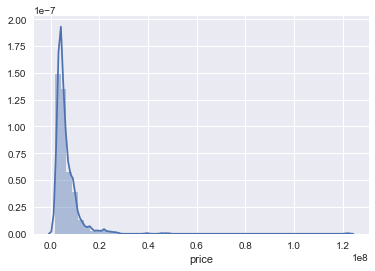

In [48]:
%matplotlib inline
import seaborn as sns
# price destribution
sns.distplot(df['price']);

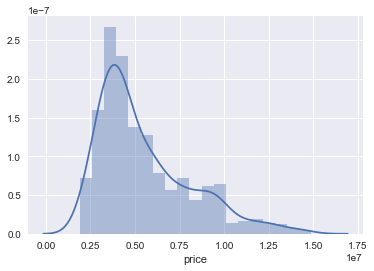

In [49]:
df = df[df['price'] < 15000000]
df = df[df['price'] > 1800000]
sns.distplot(df['price']);

In [50]:
# overall info
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 825 entries, 405549404 to 4165869916
Data columns (total 12 columns):
location       825 non-null object
navic          825 non-null object
novostavba     825 non-null object
plocha         705 non-null object
podlazi        705 non-null object
price          825 non-null int64
stavOb         796 non-null object
stavba         825 non-null object
stitky         825 non-null object
url            825 non-null object
velikost       825 non-null object
vlastnictvi    825 non-null object
dtypes: int64(1), object(11)
memory usage: 83.8+ KB


## Filling missing fields

### Užitná plocha

In [51]:
df['plocha'] = pd.to_numeric(df['plocha'], errors='coerce')

In [52]:
df[u'stavOb'].value_counts()

Novostavba    282
veryGood      240
good          129
afterRec      113
beforeRec      32
Name: stavOb, dtype: int64

### Lodžie, Novostavba, sklep, parkovani

In [53]:
def contains_converter(mapping, param):
    for i in mapping:        
        if param.find(i) > -1:
            return mapping[i]
    return ''
balcony_mapping = {
        u'balkon':u'balkon',
        u'lodzie':u'lodzie',
        u'terasa':u'terasa'    
    }

df['sklep'] = df['navic'].str.contains('sklep')
df['parkovani'] = df['navic'].str.contains('parkovani')
df['vytah'] = df['navic'].str.contains('vytah')
df['balkon'] = df['navic'].map(lambda x: contains_converter(balcony_mapping, x))
df.head(3)

,location,navic,novostavba,plocha,podlazi,price,stavOb,stavba,stitky,url,velikost,vlastnictvi,sklep,parkovani,vytah,balkon
id,,,,,,,,,,,,,,,,
405549404,"Choceradská, Praha 4 - Záběhlice",",vytah",False,58.0,3. podlaží z celkem 6,3199000,good,cihlova,,2+1/praha-zabehlice-choceradska/405549404,2+1,osobni,False,False,True,
100082012,"Vítkova, Praha 8 - Karlín",sklep,False,60.0,5. podlaží z celkem 5,3590000,good,cihlova,"Družstevní,Tramvaj 2 min. pěšky",2+1/praha-karlin-vitkova/100082012,2+1,druzstevni,True,False,False,
3563139420,"Žitomírská, Praha 10 - Vršovice","sklep,vytah",False,56.0,4. podlaží z celkem 7 včetně 1 podzemního,4050000,good,cihlova,"Částečně vybavený,Tramvaj 4 min. pěšky",2+kk/praha-vrsovice-zitomirska/3563139420,2+kk,osobni,True,False,True,


### metro and public transport

In [54]:
df = df.dropna(axis=0, how='any')
df.isnull().any()

location       False
navic          False
novostavba     False
plocha         False
podlazi        False
price          False
stavOb         False
stavba         False
stitky         False
url            False
velikost       False
vlastnictvi    False
sklep          False
parkovani      False
vytah          False
balkon         False
dtype: bool

In [55]:
df['floor'] = df['podlazi'].map(lambda x: x[:x.find(u'. podlaží z celkem ')].replace(' ',''))
df['firstFloor'] = df['floor'].map(lambda x: True if x == '1' else False)
df.head()

,location,navic,novostavba,plocha,podlazi,price,stavOb,stavba,stitky,url,velikost,vlastnictvi,sklep,parkovani,vytah,balkon,floor,firstFloor
id,,,,,,,,,,,,,,,,,,
405549404,"Choceradská, Praha 4 - Záběhlice",",vytah",False,58.0,3. podlaží z celkem 6,3199000,good,cihlova,,2+1/praha-zabehlice-choceradska/405549404,2+1,osobni,False,False,True,,3,False
100082012,"Vítkova, Praha 8 - Karlín",sklep,False,60.0,5. podlaží z celkem 5,3590000,good,cihlova,"Družstevní,Tramvaj 2 min. pěšky",2+1/praha-karlin-vitkova/100082012,2+1,druzstevni,True,False,False,,5,False
3563139420,"Žitomírská, Praha 10 - Vršovice","sklep,vytah",False,56.0,4. podlaží z celkem 7 včetně 1 podzemního,4050000,good,cihlova,"Částečně vybavený,Tramvaj 4 min. pěšky",2+kk/praha-vrsovice-zitomirska/3563139420,2+kk,osobni,True,False,True,,4,False
3486064988,"Marešova, Praha 9 - Černý Most",",parkovani,vytah",True,85.0,2. podlaží z celkem 9 včetně 2 podzemních,5450000,Novostavba,cihlova,"Novostavba,Částečně vybavený",3+kk/praha-cerny-most-maresova/3486064988,3+kk,osobni,False,True,True,,2,False
3404144988,"Amforová, Praha 5 - Stodůlky",",parkovani,vytah",False,79.0,9. podlaží z celkem 12,3650000,veryGood,panelova,"Družstevní,Lodžie,Panelová,Metro 5 min. pěšky,Sportoviště 7 min. pěšky",3+1/praha-stodulky-amforova/3404144988,3+1,druzstevni,False,True,True,,9,False


In [56]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 680 entries, 405549404 to 4165869916
Data columns (total 18 columns):
location       680 non-null object
navic          680 non-null object
novostavba     680 non-null object
plocha         680 non-null float64
podlazi        680 non-null object
price          680 non-null int64
stavOb         680 non-null object
stavba         680 non-null object
stitky         680 non-null object
url            680 non-null object
velikost       680 non-null object
vlastnictvi    680 non-null object
sklep          680 non-null bool
parkovani      680 non-null bool
vytah          680 non-null bool
balkon         680 non-null object
floor          680 non-null object
firstFloor     680 non-null bool
dtypes: bool(4), float64(1), int64(1), object(12)
memory usage: 82.3+ KB


## Model training

In [57]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

def encode_with_LabelEncoder(df, column_name):
    label_encoder = LabelEncoder()
    label_encoder.fit(df[column_name])
    df[column_name+'_le'] = label_encoder.transform(df[column_name])
    df.drop([column_name], axis=1, inplace=True)
    return label_encoder

def encode_with_existing_LabelEncoder(df, column_name, label_encoder):
    df[column_name+'_le'] = label_encoder.transform(df[column_name])
    df.drop([column_name], axis=1, inplace=True)

def encode_with_OneHotEncoder_and_delete_column(df, column_name):
    le_encoder = encode_with_LabelEncoder(df, column_name)
    return perform_dummy_coding_and_delete_column(df, column_name, le_encoder), le_encoder

def encode_with_OneHotEncoder_using_existing_LabelEncoder_and_delete_column(df, column_name, le_encoder):
    encode_with_existing_LabelEncoder(df, column_name, le_encoder)
    return perform_dummy_coding_and_delete_column(df, column_name, le_encoder)

def perform_dummy_coding_and_delete_column(df, column_name, le_encoder):
    oh_encoder = OneHotEncoder(sparse=False)
    oh_features = oh_encoder.fit_transform(df[column_name+'_le'].values.reshape(-1,1))
    ohe_columns=[column_name + '=' + le_encoder.classes_[i] for i in range(oh_features.shape[1])]

    df.drop([column_name+'_le'], axis=1, inplace=True)

    df_with_features = pd.DataFrame(oh_features, columns=ohe_columns)
    df_with_features.index = df.index
    return pd.concat([df, df_with_features], axis=1)

In [58]:
X = df.drop({'price','navic','stitky','url','podlazi'}, axis=1)
Y = df['price']
novostavba_le_converter = encode_with_LabelEncoder(X,'novostavba')
X, balcony_le_encoder = encode_with_OneHotEncoder_and_delete_column(X,'balkon')
X, stavba_le_encoder = encode_with_OneHotEncoder_and_delete_column(X,'stavba')
X, velikost_le_encoder = encode_with_OneHotEncoder_and_delete_column(X,'velikost')
X, vlastnictvi_le_encoder = encode_with_OneHotEncoder_and_delete_column(X,'vlastnictvi')
X, location_le_encoder = encode_with_OneHotEncoder_and_delete_column(X,'location')
X, stav_le_encoder = encode_with_OneHotEncoder_and_delete_column(X,'stavOb')
X, floor_le_encoder = encode_with_OneHotEncoder_and_delete_column(X,'floor')
sklep_le_encoder = encode_with_LabelEncoder(X,'sklep')
parkovani_le_encoder = encode_with_LabelEncoder(X,'parkovani')
vytah_le_encoder = encode_with_LabelEncoder(X,'vytah')
firstFloor_le_encoder = encode_with_LabelEncoder(X,'firstFloor')

X.head()

,plocha,novostavba_le,balkon=,balkon=balkon,balkon=lodzie,balkon=terasa,stavba=cihlova,stavba=ostatni,stavba=panelova,velikost=1+1,velikost=1+kk,velikost=2+1,velikost=2+kk,velikost=3+1,velikost=3+kk,velikost=4+1,velikost=4+kk,velikost=5+1,velikost=5+kk,vlastnictvi=druzstevni,vlastnictvi=osobni,vlastnictvi=statni-obecni,"location=5. května, Praha 4 - Nusle","location=Amforová, Praha 5 - Stodůlky","location=Amurská, Praha 10 - Vršovice","location=Anastázova, Praha - Břevnov","location=Anny Drabíkové, Praha 4 - Háje","location=Antala Staška, Praha 4 - Krč","location=Baranova, Praha 3 - Žižkov","location=Bedřichovská, Praha - Libeň","location=Bellušova, Praha 5 - Stodůlky","location=Bermanova, Praha 9 - Čakovice","location=Biskupcova, Praha 3 - Žižkov","location=Blanická, Praha 2 - Vinohrady","location=Bohušovická, Praha 9 - Prosek","location=Boloňská, Praha - Horní Měcholupy","location=Boloňská, Praha 10 - Horní Měcholupy","location=Borovanského, Praha - Stodůlky","location=Božanovská, Praha 9 - Horní Počernice","location=Brandlova, Praha 4 - Chodov","location=Brechtova, Praha 4 - Háje","location=Bubenečská, Praha 6 - Dejvice","location=Budějovická, Praha 4 - Krč","location=Bílinská, Praha 9 - Prosek","location=Böhmova, Praha - Stodůlky","location=Bělohorská, Praha 6 - Břevnov","location=Bělčická, Praha 4 - Záběhlice","location=Březinova, Praha 8 - Karlín","location=Chlebovická, Praha 9 - Letňany","location=Chmelová, Praha - Záběhlice","location=Choceradská, Praha 4 - Záběhlice","location=Chodovická, Praha 9 - Horní Počernice","location=Choratická, Praha 4 - Záběhlice","location=Chrudimská, Praha 3 - Vinohrady","location=Ciolkovského, Praha 6 - Ruzyně","location=Cuřínova, Praha 4 - Kamýk","location=Cílkova, Praha - Kamýk","location=Dačického, Praha 4 - Nusle","location=Daškova, Praha 4 - Modřany","location=Devonská, Praha 5 - Hlubočepy","location=Dobrovolného, Praha 9 - Černý Most","location=Dobšická, Praha 9 - Horní Počernice","location=Doubravická, Praha 4 - Chodov","location=Družstevní ochoz, Praha 4 - Nusle","location=Družstevní, Praha 4 - Nusle","location=Dudkova, Praha 9 - Letňany","location=Dvořišťská, Praha 9 - Kyje","location=Děkanská vinice I, Praha 4 - Nusle","location=Dělnická, Praha 7 - Holešovice","location=Eliášova, Praha 6 - Bubeneč","location=Evropská, Praha 6 - Dejvice","location=Fantova, Praha 5 - Stodůlky","location=Frýdlantská, Praha 8 - Kobylisy","location=Gabinova, Praha 5 - Hlubočepy","location=Gorazdova, Praha 2 - Nové Město","location=Grafická, Praha 5 - Smíchov","location=Gutova, Praha 10 - Strašnice","location=Hlubočepská, Praha 5 - Hlubočepy","location=Hnězdenská, Praha 8 - Troja","location=Holandská, Praha 10 - Vršovice","location=Holubinková, Praha 10 - Pitkovice","location=Hornocholupická, Praha 4 - Praha 12","location=Hornoměcholupská, Praha 10 - Horní Měcholupy","location=Horolezecká, Praha - Hostivař","location=Horolezecká, Praha 10 - Hostivař","location=Hostýnská, Praha 10 - Malešice","location=Hošťálkova, Praha 6 - Břevnov","location=Hradecká, Praha 3 - Vinohrady","location=Hradeckých, Praha 4 - Nusle","location=Hrudičkova, Praha - Chodov","location=Hrudičkova, Praha 4 - Chodov","location=Humpolecká, Praha - Krč","location=Hurbanova, Praha 4 - Krč","location=Husova, Praha 1 - Staré Město","location=Hviezdoslavova, Praha 4 - Háje","location=Irská, Praha 6 - Vokovice","location=Jabloňová, Praha 10 - Záběhlice","location=Jagellonská, Praha 3 - Žižkov","location=Jakobiho, Praha 10 - Petrovice","location=Jana Masaryka, Praha 2 - Vinohrady",...,"location=Ve Lhotce, Praha 4 - Kamýk","location=Velká skála, Praha 8 - Troja","location=Velké Kunratické, Praha 4 - Kunratice","location=Veltruská, Praha - Prosek","location=Veltruská, Praha 9 - Prosek","location=Verdunská, Praha 6 - Bubeneč","location=Veselská, Praha 9 - Letňany","location=Viklefova, Praha 3 - Žižkov","location=Vinohradská, Praha 10 - Strašnice","location=Vinohradská, Praha 2 - Vinohrady","location=Vladycká, Praha 10 - Hostivař","location=Vl

In [59]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection  import KFold
from sklearn.model_selection  import cross_val_score
n_folds = 5
records_count = Y.count()
kf = KFold(n_splits=n_folds, shuffle=True, random_state=1)

In [60]:
%%time
from sklearn.model_selection import GridSearchCV
scores = list()
scores_std = list()


def determine_forest_quality(trees_count):
    clf = RandomForestRegressor(n_estimators = trees_count, random_state=1)
    score = cross_val_score(clf, X, Y, scoring='r2', cv=kf)
    scores.append(np.mean(score))
    scores_std.append(np.std(score))
    return score.mean()

for k in range(1,62,5):
    quality = determine_forest_quality(k)    
    print (k, quality)
    

(1, 0.57661245746206258)
(6, 0.69385816133547773)
(11, 0.70917999725355829)
(16, 0.71160595673258031)
(21, 0.71378293735049769)
(26, 0.71653216482876714)
(31, 0.71812038905541586)
(36, 0.71691197225819592)
(41, 0.71987236079460326)
(46, 0.72062353551086344)
(51, 0.72017172733817825)
(56, 0.72073471126143551)
(61, 0.71952191358719964)
CPU times: user 22.5 s, sys: 171 ms, total: 22.7 s
Wall time: 22.7 s


(0.10000000000000001, 0.31622776601683794)

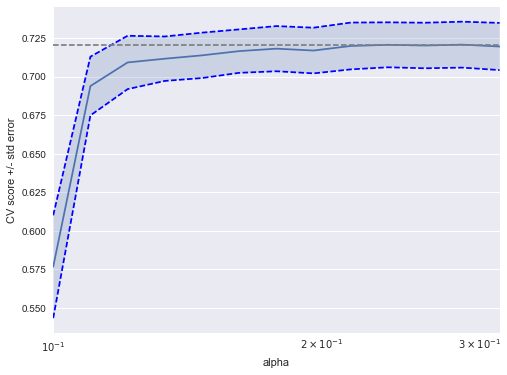

In [61]:
import matplotlib.pyplot as plt
scores, scores_std = np.array(scores), np.array(scores_std)
alphas = np.logspace(-1, -0.5, 13)

plt.figure().set_size_inches(8, 6)
plt.semilogx(alphas, scores)

std_error = scores_std / np.sqrt(n_folds)

plt.semilogx(alphas, scores + std_error, 'b--')
plt.semilogx(alphas, scores - std_error, 'b--')
plt.fill_between(alphas, scores + std_error, scores - std_error, alpha=0.2)

plt.ylabel('CV score +/- std error')
plt.xlabel('alpha')
plt.axhline(np.max(scores), linestyle='--', color='.5')
plt.xlim([alphas[0], alphas[-1]])

In [62]:
clf = RandomForestRegressor(n_estimators = 51, random_state=1)
clf.fit(X, Y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=51, n_jobs=1, oob_score=False, random_state=1,
           verbose=0, warm_start=False)

In [63]:
# top 20 features:
features = X.columns.values
importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]

num_to_plot = 20
feature_indices = [ind+1 for ind in indices[:num_to_plot]]

for i in range(num_to_plot):
    print features[feature_indices[i]], round(importances[indices[i]],4)

novostavba_le 0.713
velikost=1+1 0.0497
location=Jeronýmova, Praha 3 - Žižkov 0.0161
location=Národní obrany, Praha 6 - Bubeneč 0.0098
location=Hviezdoslavova, Praha 4 - Háje 0.0086
location=Libická, Praha - Vinohrady 0.0078
location=Na Pankráci, Praha 4 - Nusle 0.0075
velikost=4+1 0.0064
floor=6 0.0059
velikost=3+kk 0.0056
stavOb=veryGood 0.0054
location=Zákostelní, Praha 9 - Vysočany 0.0051
location=K Červenému dvoru, Praha 3 - Strašnice 0.0044
location=Roháčova, Praha 3 - Žižkov 0.0042
velikost=3+1 0.004
stavOb=Novostavba 0.0039
stavOb=beforeRec 0.0038
location=Praha 1 - Vinohrady 0.0037
floor=7 0.0034
location=Praha 3 - Strašnice 0.0033


In [64]:
predictions = pd.Series(clf.predict(X), index=Y.index)
res_info = pd.DataFrame(columns=['Error,%',u'Error,Kč',u'Price,Kč',u'Price,m²', u'URL'])
for i in Y.index:
    error = Y[i] - predictions[i]
    rel_error = error/predictions[i]*100
    #if np.abs(rel_error)>15:
    res_info.loc[i] = pd.Series({
            'Error,%':round(rel_error,1),
            u'Error,Kč':'{:,}'.format(int(error)),
            u'Price,Kč':'{:,}'.format(Y[i]),
            u'Price,m²':'{:,}'.format(int(Y[i]/X['plocha'][i])),
            'URL':'{}/{}/'.format(' https://www.sreality.cz/detail/prodej/byt', df['url'][i])
    })
    
# Underpriced offers
pd.options.display.max_colwidth = 100
res_info.sort_values(by=u'Error,%')[:15]

,"Error,%","Error,Kč","Price,Kč","Price,m²",URL
3602174300,-25.6,"-1,926,000","5,590,000","39,928",https://www.sreality.cz/detail/prodej/byt/4+kk/praha-sterboholy-/3602174300/
631619932,-25.3,"-1,690,937","4,990,000","43,391",https://www.sreality.cz/detail/prodej/byt/5+kk/praha-ujezd-nad-lesy-malesovska/631619932/
2479264092,-22.9,"-1,808,823","6,100,000","44,202",https://www.sreality.cz/detail/prodej/byt/5+kk/praha-zbraslav-sulova/2479264092/
3055989084,-22.6,"-1,252,186","4,299,000","45,252",https://www.sreality.cz/detail/prodej/byt/3+1/praha-modrany-karasova/3055989084/
1318658396,-22.1,"-1,712,028","6,038,811","41,080",https://www.sreality.cz/detail/prodej/byt/3+kk/praha-modrany-k-vystrkovu/1318658396/
2503926108,-20.3,"-1,438,431","5,650,000","53,301",https://www.sreality.cz/detail/prodej/byt/4+kk/praha-ujezd-u-pruhonic-nad-statkem/2503926108/
1018728796,-19.7,"-728,874","2,967,320","41,212",https://www.sreality.cz/detail/prodej/byt/2+1/praha-praha-14-/1018728796/
1153311068,-19.1,"-1,368,690","5,790,000","56,213",https://www.sreality.cz/detail/prodej/byt/3+kk/praha-horni-pocernice-bozanovska/1153311068/
3043045724,-18.2,"-878,294","3,960,000","52,800",https://www.sreality.cz/detail/prodej/byt/2+kk/praha-chodov-sternovska/3043045724/
2134782300,-17.9,"-448,367","2,050,000","45,555",https://www.sreality.cz/detail/prodej/byt/2+1/praha-smichov-ke-koulce/2134782300/


In [65]:
# Overpriced offers
res_info.sort_values(by='Error,%', ascending=False)[:15]

,"Error,%","Error,Kč","Price,Kč","Price,m²",URL
145596764,29.3,"2,538,874","11,200,000","175,000",https://www.sreality.cz/detail/prodej/byt/2+kk/praha-stare-mesto-husova/145596764/
145109340,25.4,"2,832,311","13,970,000","186,266",https://www.sreality.cz/detail/prodej/byt/2+kk/praha-podoli-jeremenkova/145109340/
3336425820,23.4,"1,307,647","6,900,000","115,000",https://www.sreality.cz/detail/prodej/byt/2+1/praha-bubenec-cs--armady/3336425820/
1315119452,23.2,"1,392,294","7,400,000","148,000",https://www.sreality.cz/detail/prodej/byt/2+kk/praha-stare-mesto-u-obecniho-dvora/1315119452/
1816666460,23.1,"2,251,753","11,990,000","184,461",https://www.sreality.cz/detail/prodej/byt/2+kk/praha-smichov-nadrazni/1816666460/
668934492,22.9,"1,638,601","8,800,000","176,000",https://www.sreality.cz/detail/prodej/byt/2+1/praha-vinohrady-zahrebska/668934492/
1237266780,22.7,"1,942,558","10,500,000","150,000",https://www.sreality.cz/detail/prodej/byt/3+kk/praha-stresovice-na-orechovce/1237266780/
4293665116,22.4,"1,575,508","8,600,000","128,358",https://www.sreality.cz/detail/prodej/byt/2+1/praha-praha-1-/4293665116/
3231461724,21.4,"1,741,570","9,884,344","128,368",https://www.sreality.cz/detail/prodej/byt/3+kk/praha--k-cervenemu-dvoru/3231461724/
2744762716,17.9,"1,974,515","12,990,000","90,208",https://www.sreality.cz/detail/prodej/byt/3+kk/praha-smichov-krizova/2744762716/


In [66]:
import xgboost as xgb
scores = list()
scores_std = list()
def determine_forest_quality(trees_count):
    clf = xgb.XGBRegressor(n_estimators = trees_count, max_depth = 5)
    score = cross_val_score(clf, X, Y, scoring='r2', cv=kf)
    scores.append(np.mean(score))
    scores_std.append(np.std(score))
    return score.mean()

for k in range(1,62,5):
    quality = determine_forest_quality(k)    
    print (k, quality)


(1, -3.5520026467965322)
(6, -0.7888579078366218)
(11, 0.1824454946429665)
(16, 0.51992390252943588)
(21, 0.63808306707949458)
(26, 0.68218195186690933)
(31, 0.70096607059662097)
(36, 0.70961086366965076)
(41, 0.71249498840046055)
(46, 0.71502300658026052)
(51, 0.7160005744080723)
(56, 0.71657562260050756)
(61, 0.71742461902424048)


(1.0000000000000001e-05, 0.31622776601683794)

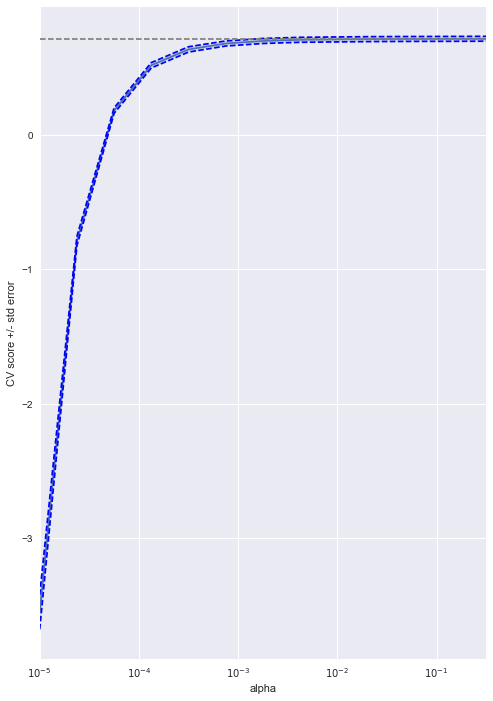

In [75]:
scores, scores_std = np.array(scores), np.array(scores_std)
alphas = np.logspace(-5, -0.5, 13)

plt.figure().set_size_inches(8, 12)
plt.semilogx(alphas, scores)

std_error = scores_std / np.sqrt(n_folds)

plt.semilogx(alphas, scores + std_error, 'b--')
plt.semilogx(alphas, scores - std_error, 'b--')
plt.fill_between(alphas, scores + std_error, scores - std_error, alpha=0.2)

plt.ylabel('CV score +/- std error')
plt.xlabel('alpha')
plt.axhline(np.max(scores), linestyle='--', color='.5')
plt.xlim([alphas[0], alphas[-1]])

In [68]:
clf = xgb.XGBRegressor(n_estimators = 51, max_depth = 5)
clf.fit(X, Y)
features = X.columns.values
importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]

num_to_plot = 20
feature_indices = [ind+1 for ind in indices[:num_to_plot]]

for i in range(num_to_plot):
    print features[feature_indices[i]], round(importances[indices[i]],4)

novostavba_le 0.2485
velikost=1+1 0.0632
location=Jeronýmova, Praha 3 - Žižkov 0.0368
location=Národní obrany, Praha 6 - Bubeneč 0.0294
vlastnictvi=osobni 0.0294
location=Hviezdoslavova, Praha 4 - Háje 0.0265
location=Libická, Praha - Vinohrady 0.025
velikost=4+1 0.025
stavOb=veryGood 0.0235
location=Na Pankráci, Praha 4 - Nusle 0.0221
location=Zákostelní, Praha 9 - Vysočany 0.0191
velikost=3+1 0.0191
location=Roháčova, Praha 3 - Žižkov 0.0176
location=K Červenému dvoru, Praha 3 - Strašnice 0.0176
floor=3 0.0147
location=Spinozova, Praha - Modřany 0.0147
velikost=3+kk 0.0132
location=Praha 3 - Strašnice 0.0118
stavba=ostatni 0.0118
location=Praha 1 - Vinohrady 0.0103


In [69]:
predictions = pd.Series(clf.predict(X), index=Y.index)
res_info = pd.DataFrame(columns=['Error,%',u'Error,Kč',u'Price,Kč',u'Price,m²', u'URL'])
for i in Y.index:
    error = Y[i] - predictions[i]
    rel_error = error/predictions[i]*100
    #if np.abs(rel_error)>15:
    res_info.loc[i] = pd.Series({
            'Error,%':round(rel_error,1),
            u'Error,Kč':'{:,}'.format(int(error)),
            u'Price,Kč':'{:,}'.format(Y[i]),
            u'Price,m²':'{:,}'.format(int(Y[i]/X['plocha'][i])),
            'URL':'{}/{}/'.format(' https://www.sreality.cz/detail/prodej/byt', df['url'][i])
    })
    
# Underpriced offers
pd.options.display.max_colwidth = 100
res_info.sort_values(by=u'Error,%')[:15]

,"Error,%","Error,Kč","Price,Kč","Price,m²",URL
1018728796,-33.9,"-1,525,042","2,967,320","41,212",https://www.sreality.cz/detail/prodej/byt/2+1/praha-praha-14-/1018728796/
2265391452,-32.1,"-2,782,860","5,890,000","51,666",https://www.sreality.cz/detail/prodej/byt/2+kk/praha-hlubocepy-hlubocepska/2265391452/
2823999836,-30.5,"-1,240,353","2,830,000","54,423",https://www.sreality.cz/detail/prodej/byt/2+kk/praha-nusle-na-jezerce/2823999836/
2227384668,-30.3,"-1,690,721","3,890,000","51,184",https://www.sreality.cz/detail/prodej/byt/4+kk/praha-zabehlice-svojsovicka/2227384668/
795287900,-29.4,"-1,459,196","3,500,000","53,846",https://www.sreality.cz/detail/prodej/byt/3+1/praha-praha-10-limuzska/795287900/
1852977500,-29.0,"-1,344,483","3,298,000","52,349",https://www.sreality.cz/detail/prodej/byt/3+kk/praha-horni-mecholupy-modenska/1852977500/
2887459164,-28.3,"-1,231,851","3,117,093","57,723",https://www.sreality.cz/detail/prodej/byt/2+kk/praha-letnany-miroslava-hajna/2887459164/
1377575260,-28.2,"-1,370,440","3,490,000","49,154",https://www.sreality.cz/detail/prodej/byt/3+1/praha-liben-strizkovska/1377575260/
3037143388,-26.6,"-1,012,572","2,790,000","54,705",https://www.sreality.cz/detail/prodej/byt/2+1/praha-vysocany-u-vysocanskeho-pivovaru/3037143388/
3249480028,-26.2,"-1,139,944","3,209,000","62,921",https://www.sreality.cz/detail/prodej/byt/2+kk/praha-letnany-veselska/3249480028/
